# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [47]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device, keep_all = True
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [48]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [93]:
from PIL import Image, ImageDraw
aligned_faces = []
picture_tracked = []
detected_faces = [] 
image_paths = ["./drama/drama_01","./drama/drama_02"] 
for p in image_paths:
    for img in os.listdir(p):
        im = Image.open(os.path.join(p, img))
        im = im.convert('RGB')
        boxes, _ = mtcnn.detect(im)
        aligned, prob= mtcnn(im, return_prob=True)
        if aligned is not None:
            for a in aligned: 
                aligned_faces.append(a)
        if boxes is None:
            continue
        frame_draw = im.copy()
        draw = ImageDraw.Draw(frame_draw)
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
            face = frame_draw.crop(box)
            detected_faces.append(face)
        picture_tracked.append(frame_draw)

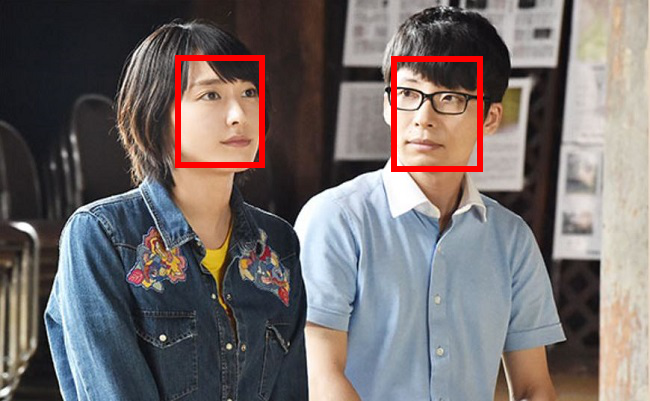

In [34]:
from IPython import display

d = display.display(picture_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(picture_tracked[i % len(picture_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

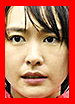

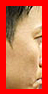

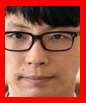

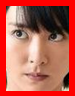

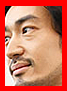

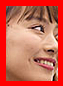

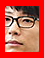

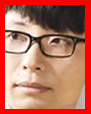

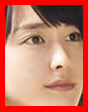

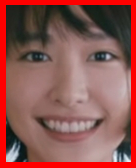

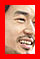

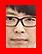

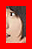

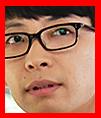

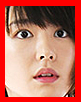

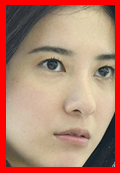

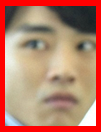

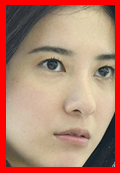

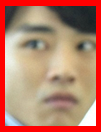

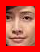

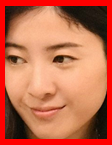

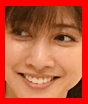

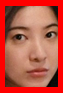

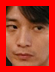

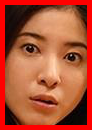

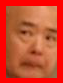

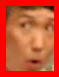

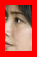

In [36]:
for face in enumerte(detected_faces):
    display.display(face, display_id=True)

In [65]:
names = ["新垣結衣", "配角1", "星野源", "新垣結衣2", "配角2",
         "配角3", "星野源2", "星野源3", "新垣結衣3", "新垣結衣4",
         "配角2-2", "星野源4", "新垣結衣5", "星野源5","新垣結衣6", "吉高由里子",
         "配角4", "吉高由里子2","配角4","內田有紀","吉高由里子3","內田有紀2","吉高由里子4",
         "向井理","吉高由里子5", "配角5", "配角6","內田有紀3"]

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [66]:
aligned = torch.stack(tuple(aligned_faces)).to(device)

embeddings = resnet(aligned).detach().cpu()
embeddings

tensor([[ 0.0039, -0.0133, -0.0193,  ...,  0.0053, -0.0106,  0.0948],
        [ 0.0587,  0.0370, -0.0230,  ..., -0.0130,  0.0542,  0.0270],
        [ 0.0298,  0.0072, -0.0549,  ..., -0.0665,  0.0125, -0.0271],
        ...,
        [ 0.0755,  0.0061,  0.0737,  ..., -0.0660, -0.0589,  0.0326],
        [ 0.0806, -0.0204,  0.0039,  ..., -0.0047,  0.0597,  0.0253],
        [ 0.0741, -0.0309, -0.0320,  ..., -0.0421, -0.0270,  0.0643]])

In [67]:
embeddings.shape

torch.Size([28, 512])

#### Print distance matrix for classes

In [68]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
df = pd.DataFrame(dists, columns=names, index=names)
df 

,新垣結衣,配角1,星野源,新垣結衣2,配角2,配角3,星野源2,星野源3,新垣結衣3,新垣結衣4,...,配角4,內田有紀,吉高由里子3,內田有紀2,吉高由里子4,向井理,吉高由里子5,配角5,配角6,內田有紀3
新垣結衣,0.000000,1.343662,1.208726,0.815007,1.250100,0.879350,1.241082,1.251510,0.743812,0.633372,...,1.255798,1.052313,1.105719,0.986124,1.109386,1.179677,0.930957,1.305174,1.390276,0.863250
配角1,1.343662,0.000000,1.175419,1.321910,1.272980,1.273409,1.141824,1.174296,1.375286,1.349742,...,1.234462,1.328346,1.400877,1.392173,1.409197,1.149682,1.404097,1.260387,1.058240,1.394297
星野源,1.208726,1.175419,0.000000,1.283399,1.099098,1.230183,0.655812,0.564319,1.278070,1.286318,...,1.291326,1.095719,1.300190,1.174783,1.222568,1.005991,1.222410,1.254288,1.249173,1.292547
新垣結衣2,0.815007,1.321910,1.283399,0.000000,1.406008,0.916996,1.278525,1.256163,0.881821,0.897250,...,1.147891,1.148591,1.142945,0.986131,1.139858,1.302935,1.013478,1.334812,1.408982,0.910367
配角2,1.250100,1.272980,1.099098,1.406008,0.000000,1.252074,1.187206,1.138900,1.271630,1.313291,...,1.026008,1.171237,1.328877,1.413951,1.404775,1.010110,1.345110,1.202012,1.281858,1.393233
配角3,0.879350,1.273409,1.230183,0.916996,1.252074,0.000000,1.224495,1.254237,0.845533,0.915711,...,1.184031,1.087771,1.142089,0.981378,1.149196,1.213096,1.089724,1.289046,1.539228,0.981640
星野源2,1.241082,1.141824,0.655812,1.278525,1.187206,1.224495,0.000000,0.492389,1.285894,1.321843,...,1.191239,1.088557,1.295897,1.229173,1.214382,0.930727,1.146411,1.262709,1.171845,1.254270
星野源3,1.251510,1.174296,0.564319,1.256163,1.138900,1.254237,0.492389,0.000000,1.292229,1.263097,...,1.163598,1.081912,1.329887,1.212350,1.241500,0.999138,1.199750,1.253496,1.228245,1.237191
新垣結衣3,0.743812,1.375286,1.278070,0.881821,1.271630,0.845533,1.285894,1.292229,0.000000,0.701670,...,1.146967,1.163473,1.173839,1.154564,1.178651,1.241073,1.048494,1.438114,1.534558,1.041927
新垣結衣4,0.633372,1.349742,1.286318,0.897250,1.313291,0.915711,1.321843,1.263097,0.701670,0.000000,...,1.210050,1.160445,1.263507,1.012885,1.168824,1.135957,1.120347,1.411877,1.436316,0.995338


findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


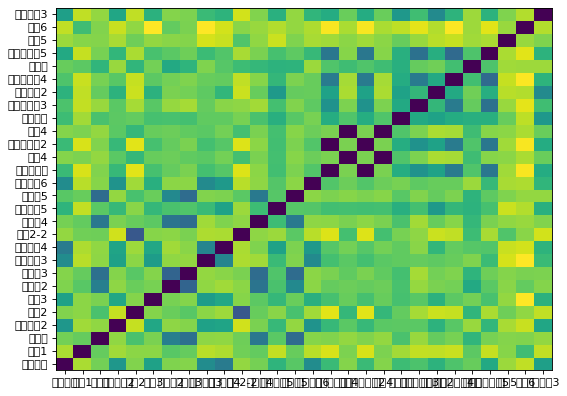

In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.pcolor(df)

In [80]:
!pip install requests 
!pip install requests-aws4auth
!pip install Elasticsearch==7.12.1
!pip install urllib3

     |████████████████████████████████| 339 kB 6.9 MB/s eta 0:00:01


In [82]:
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
import boto3

host = 'search-image-retrieval-bnppfgqwzoeu5dugmryflqaboa.us-west-2.es.amazonaws.com' # For example, my-test-domain.us-east-1.es.amazonaws.com
region = 'us-west-2' # e.g. us-west-1

service = 'es'
credentials = boto3.Session().get_credentials()



es = Elasticsearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = ('root','Peggy@@0218'),
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [48]:
# es.indices.delete(index='faces', ignore=[400, 404])


{'acknowledged': True}

In [83]:
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "face_vector": {
                "type": "knn_vector",
                "dimension": 512
            }
        }
    }
}

es.indices.create(index="faces",body=knn_index,ignore=400)

{'error': {'root_cause': [{'type': 'resource_already_exists_exception',
    'reason': 'index [faces/gaQjXgJYQZqeVz9e8pOnLg] already exists',
    'index_uuid': 'gaQjXgJYQZqeVz9e8pOnLg',
    'index': 'faces'}],
  'type': 'resource_already_exists_exception',
  'reason': 'index [faces/gaQjXgJYQZqeVz9e8pOnLg] already exists',
  'index_uuid': 'gaQjXgJYQZqeVz9e8pOnLg',
  'index': 'faces'},
 'status': 400}

In [84]:
def es_import(vector, celebid, id):
    es.index(index='faces',
             id=id, 
             body={"face_vector": vector, 
                   "celebid":celebid})
        
# es_import([0 for i in range(0, 256)], "q1")

In [85]:
for idx, (name, vector) in enumerate(zip(names, embeddings)): 
    es_import(vector.tolist(), name, idx)
    

In [86]:
def post(vector):
    res = es.search(index="faces",
                    body={
                        "size": 5,
                            "_source": {
                                "exclude": ["face_vector"]
                            },
                            "min_score": 0.3,
                            "query": {
                                "knn": {
                                    "face_vector": {
                                        "vector": vector,
                                        "k": 5
                                    }
                                }
                            }
                    })
    return res



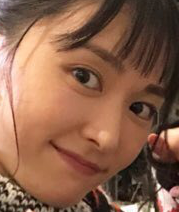

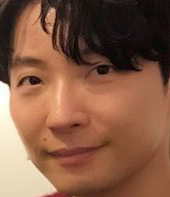

{'took': 8, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.7305113, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '9', '_score': 0.7305113, '_source': {'celebid': '新垣結衣4'}}, {'_index': 'faces', '_type': '_doc', '_id': '8', '_score': 0.66304576, '_source': {'celebid': '新垣結衣3'}}, {'_index': 'faces', '_type': '_doc', '_id': '0', '_score': 0.609805, '_source': {'celebid': '新垣結衣'}}, {'_index': 'faces', '_type': '_doc', '_id': '14', '_score': 0.5883469, '_source': {'celebid': '新垣結衣6'}}, {'_index': 'faces', '_type': '_doc', '_id': '5', '_score': 0.5807431, '_source': {'celebid': '配角3'}}]}}
{'took': 10, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.67049056, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '2', '_score': 0.67049056, '_source': {'celebid': '星野源'}}, {'_in

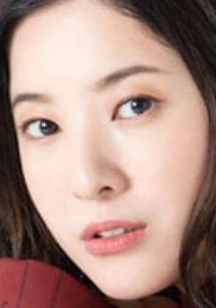

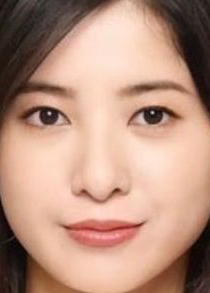

{'took': 10, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.78113884, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '24', '_score': 0.78113884, '_source': {'celebid': '吉高由里子5'}}, {'_index': 'faces', '_type': '_doc', '_id': '17', '_score': 0.7377863, '_source': {'celebid': '吉高由里子2'}}, {'_index': 'faces', '_type': '_doc', '_id': '15', '_score': 0.7377863, '_source': {'celebid': '吉高由里子'}}, {'_index': 'faces', '_type': '_doc', '_id': '22', '_score': 0.6921639, '_source': {'celebid': '吉高由里子4'}}, {'_index': 'faces', '_type': '_doc', '_id': '20', '_score': 0.669471, '_source': {'celebid': '吉高由里子3'}}]}}
{'took': 8, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.73732126, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '17', '_score': 0.73732126, '_source': {'celebid': '

In [92]:
p="./drama/"
test_aligned = []
for img in ['test1.jpeg', 'test2.jpg']:
    im = Image.open(os.path.join(p, img))
    im = im.convert('RGB')
    boxes, _ = mtcnn.detect(im)
    aligned, prob= mtcnn(im, return_prob=True)
    for b in boxes: 
        display.display(im.crop(b), display_id=True)

    aligned = torch.stack(tuple(aligned)).to(device)
    embeddings = resnet(aligned).detach().cpu()
    for emb in embeddings:
        result = post(emb.tolist())
        print(result)
        